# Лабораторная работа 6.

# Cегментация изображений


В этой работе рассматриваются методы сегментации изображений.

Цель лабораторной работы: научиться применять методы сегментации изображений.


### Дополнительные библиотеки

- https://scikit-learn.org/stable/
- conda install -c anaconda scikit-learn==0.24.1

- https://scikit-image.org/
- conda install -c anaconda scikit-image==0.18.0

In [ ]:
#%reset
#!pip install scikit-image==0.18.0

In [2]:
import numpy as np
import cv2 as cv
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import KMeans
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage import data
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import math

### Загрузим изображение

In [3]:
image = cv.imread('./ape.bmp')
image_hsv = cv.cvtColor(image, cv.COLOR_RGB2HSV)
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

### 1 Основанные на регионах (Region-based)  Разрастание областей (region growing)

Этот класс алгоритмов эксплуатирует идею, что находящиеся рядом пиксели и при этом схожие по яркости (цвету) должны находиться в одном сегменте.

Существует два основных подхода – объединение пикселей в сегменты и разделение крупных частей изображения на сегменты.

Алгоритм разрастания областей (region growing) - метод сегментации изображения, который работает по принципу итеративного объединения пикселей в области на основе их сходства с начальным (seed) пикселем.

1. Выбор начального значения. Могут быть выбраны вручную, случайным образом или автоматически.

2. Вычисление сходства. Значение меры сходства определяет, следует ли включать пиксель в увеличивающуюся область. Мера сходства может быть основана на яркости пикселей, цвете, текстуре или комбинации признаков.

3. Определение связности. Алгоритм учитывает связность между соседними пикселями (например, 4 и 8-пиксельную).  
<figure>
<center>
<img src='https://drive.google.com/uc?id=1q388t8ejlqobsBMhBEdEcnJg0iQr33o4' />
<figcaption></figcaption></center>
</figure>

Определяем координаты начальных точек и порог похожести для цвета

In [4]:
# определяем координаты начальных точек
seeds = [(100, 100), (50, 125), (50, 225), (210, 119),(170, 190),(230, 210)]
# координаты для графика
x = list(map(lambda x: x[1], seeds))
y = list(map(lambda x: x[0], seeds))
# порог похожести цвета региона
threshold = 100

Функция, реализующая алгоритм разрастания регионов:

In [5]:
def region_growingHSV(image, seed, threshold):
    # Create an empty binary mask to store the segmented region
    region_mask = np.zeros(image.shape[0:2], dtype=np.uint8)

    # Define the connectivity (4-connectivity in this case)
    connectivity = [(1, 0), (-1, 0), (0, 1), (0, -1)]
    # Create a queue to store the pixels to be processed
    queue = []

    for i in seed:
        # Get the seed coordinates
        seed_x, seed_y = i
        queue.append((seed_x, seed_y))

        # Perform region growing
        while len(queue) > 0:
            x, y = queue.pop(0)

            # Check if the pixel is within the image boundaries
            if x < 0 or x >= image.shape[0] or y < 0 or y >= image.shape[1]:
                continue

            # Check if the pixel has already been visited
            if region_mask[x, y] != 0:
                continue

            # Calculate the similarity measure
            similarity = sum(abs(image[x, y, :] - image[seed_x, seed_y, :]))/3

            # Check if the pixel is similar to the seed pixel
            if similarity < threshold:
                region_mask[x, y] = 255  # Add the pixel to the region
                # Add the neighbors to the queue for further processing
                for dx, dy in connectivity:
                    queue.append((x + dx, y + dy))

    return region_mask

Находим сегментацию используя метод разрастания регионов и отображаем результат

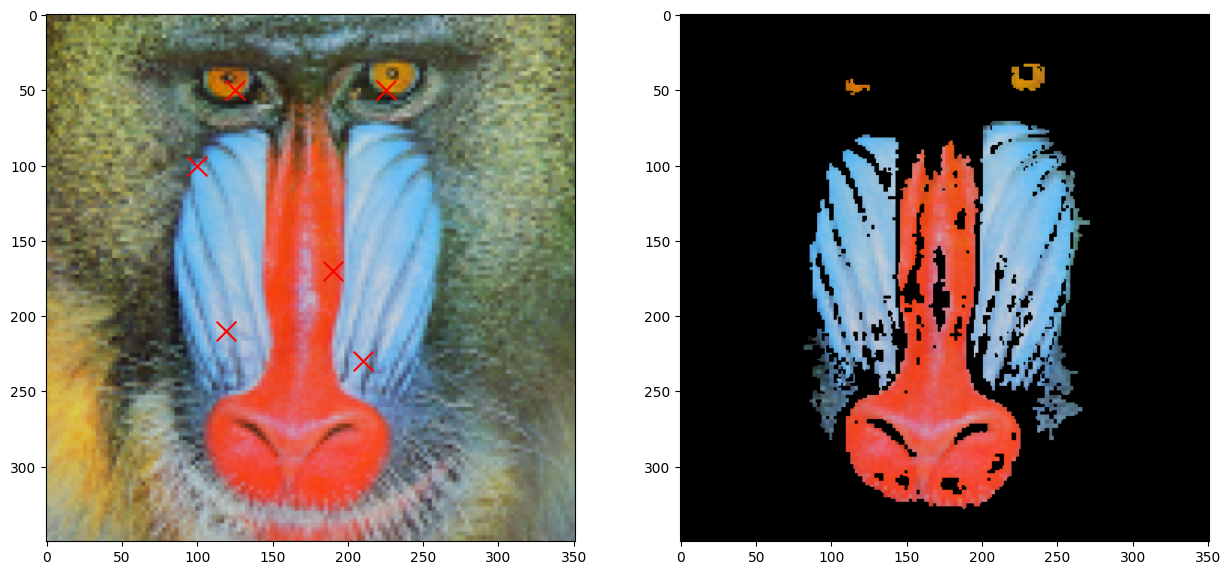

In [6]:
# находим сегментацию используя метод из segmentation_utils
segmented_region = region_growingHSV(image_hsv, seeds, threshold)
# накладываем маску - отображаем только участки попавшие в какой-либо сегмент
result = cv.bitwise_and(image, image, mask=segmented_region)
# отображаем полученное изображение
plt.figure(figsize=(15,20))
plt.subplot(1, 2, 1)
plt.scatter(x, y, marker="x", color="red", s=200)
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()

### Основанные на регионах (Region-based). Метод деления (Split segmentation)

Алгоритм основан на идее, что если область изображения неоднородна, то ее необходимо разделить.

1 Всё изображение есть сегмент, помещаем его в очередь.

2. Пока очередь не пуста

   2.1 Взять сегмент Si из очереди

   2.2 Вычислить меру однородности сегмента
   
   2.3 Если сегмент неоднороден, то разделить, поместив части в очередь.
   
Деление часто делают на 4 части, тогда возникает структура - квадродерево.

Функция и классы, реализующие метод деления:

In [7]:
def recursive_subdivide(node, k, minPixelSize, img):

    if node.get_error(img)<=k:
        return
    w_1 = int(math.floor(node.width/2))
    w_2 = int(math.ceil(node.width/2))
    h_1 = int(math.floor(node.height/2))
    h_2 = int(math.ceil(node.height/2))


    if w_1 <= minPixelSize or h_1 <= minPixelSize:
        return
    x1 = Node(node.x0, node.y0, w_1, h_1) # top left
    recursive_subdivide(x1, k, minPixelSize, img)

    x2 = Node(node.x0, node.y0+h_1, w_1, h_2) # btm left
    recursive_subdivide(x2, k, minPixelSize, img)

    x3 = Node(node.x0 + w_1, node.y0, w_2, h_1)# top right
    recursive_subdivide(x3, k, minPixelSize, img)

    x4 = Node(node.x0+w_1, node.y0+h_1, w_2, h_2) # btm right
    recursive_subdivide(x4, k, minPixelSize, img)

    node.children = [x1, x2, x3, x4]


def find_children(node):
   if not node.children:
       return [node]
   else:
       children = []
       for child in node.children:
           children += (find_children(child))
   return children

class Node():
    def __init__(self, x0, y0, w, h):
        self.x0 = x0
        self.y0 = y0
        self.width = w
        self.height = h
        self.children = []

    def get_width(self):
        return self.width

    def get_height(self):
        return self.height

    def get_points(self):
        return self.points

    def get_points(self, img):
        return img[self.x0:self.x0 + self.get_width(), self.y0:self.y0+self.get_height()]

    def get_error(self, img):
        pixels = self.get_points(img)
        b_avg = np.mean(pixels[:,:,0])
        b_mse = np.square(np.subtract(pixels[:,:,0], b_avg)).mean()

        g_avg = np.mean(pixels[:,:,1])
        g_mse = np.square(np.subtract(pixels[:,:,1], g_avg)).mean()

        r_avg = np.mean(pixels[:,:,2])
        r_mse = np.square(np.subtract(pixels[:,:,2], r_avg)).mean()

        e = r_mse * 0.2989 + g_mse * 0.5870 + b_mse * 0.1140

        return (e * img.shape[0]* img.shape[1])/90000000


class QTree():
    def __init__(self, stdThreshold, minPixelSize, img):
        self.threshold = stdThreshold
        self.min_size = minPixelSize
        self.minPixelSize = minPixelSize
        self.img = img
        self.root = Node(0, 0, img.shape[0], img.shape[1])

    def get_points(self):
        return self.img[self.root.x0:self.root.x0 + self.root.get_width(), self.root.y0:self.root.y0+self.root.get_height()]

    def subdivide(self):
        recursive_subdivide(self.root, self.threshold, self.minPixelSize, self.img)

    def graph_tree(self):
        fig = plt.figure(figsize=(10, 10))
        plt.title("Quadtree")
        c = find_children(self.root)
        print("Number of segments: %d" %len(c))
        for n in c:
            plt.gcf().gca().add_patch(patches.Rectangle((n.y0, n.x0), n.height, n.width, fill=False))
        plt.gcf().gca().set_xlim(0,self.img.shape[1])
        plt.gcf().gca().set_ylim(self.img.shape[0], 0)
        plt.axis('equal')
        plt.show()
        return

    def render_img(self, thickness = 1, color = (0,0,255)):
        imgc = self.img.copy()
        c = find_children(self.root)
        for n in c:
            pixels = n.get_points(self.img)
            # grb
            gAvg = math.floor(np.mean(pixels[:,:,0]))
            rAvg = math.floor(np.mean(pixels[:,:,1]))
            bAvg = math.floor(np.mean(pixels[:,:,2]))

            imgc[n.x0:n.x0 + n.get_width(), n.y0:n.y0+n.get_height(), 0] = gAvg
            imgc[n.x0:n.x0 + n.get_width(), n.y0:n.y0+n.get_height(), 1] = rAvg
            imgc[n.x0:n.x0 + n.get_width(), n.y0:n.y0+n.get_height(), 2] = bAvg

        if thickness > 0:
            for n in c:
                # Draw a rectangle
                imgc = cv.rectangle(imgc, (n.y0, n.x0), (n.y0+n.get_height(), n.x0+n.get_width()), color, thickness)
        return imgc



Находим сегментацию используя метод деления и отображаем результат



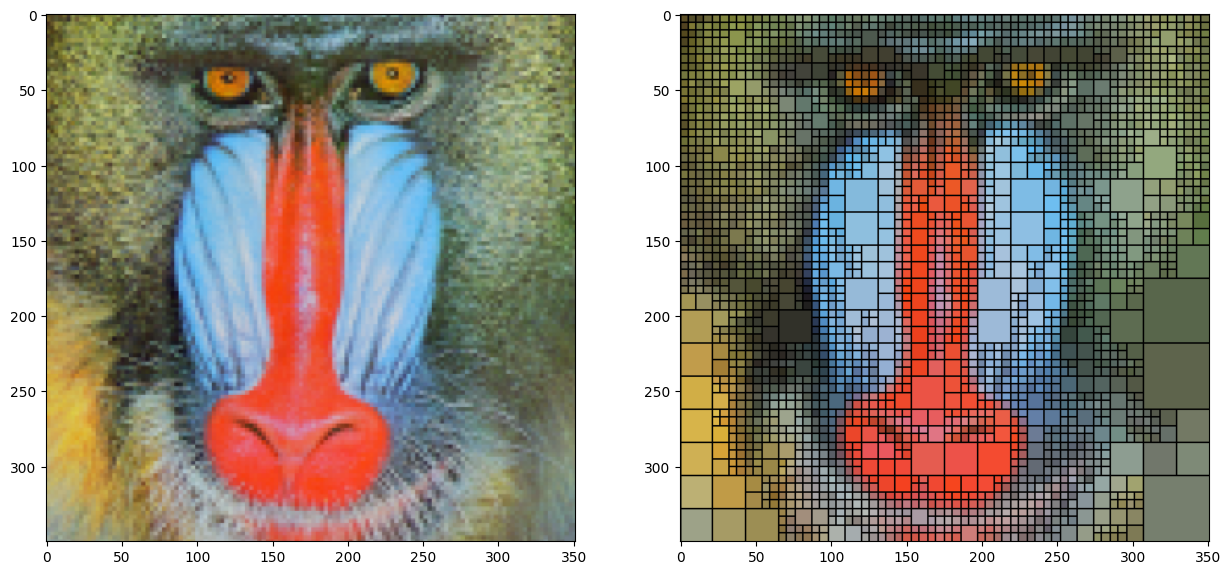

In [8]:
qt = QTree(stdThreshold = 0.25, minPixelSize = 4,img = image.copy())
qt.subdivide()
tree_image = qt.render_img(thickness=1, color=(0,0,0))

plt.figure(figsize=(15,20))
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(tree_image, cv.COLOR_BGR2RGB))
plt.show()


### Алгоритм водораздела (Watershed)

Алгоритм основан на представлении изображения как топографической поверхности, заполняемой водой. Тогда границы сегментов – это линии водораздела.

На такой поверхности существует 3 типа точек:

  1 Локальные минимумы.

  2 Точки, в которых вода скатывается в  единственный локальный минимум.

  3 Точки, в которых вода может с равной вероятностью скатиться в несколько минимумов.

Точки, удовлетворяющие 2-му условию, называются водосборным бассейном.

Точки, которые удовлетворяют 3-му условию, называются линиями водораздела. Их необходимо найти.

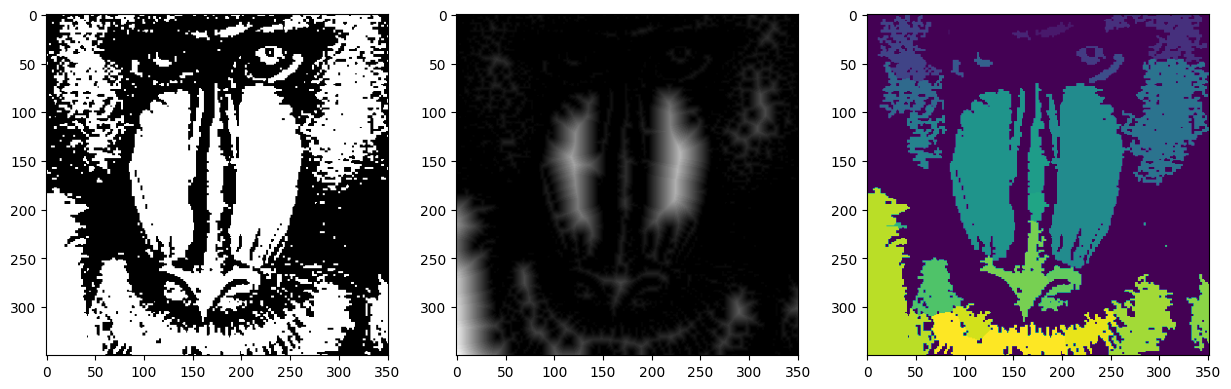

In [9]:
# Алгоритм водораздела
# Бинаризируем изображение
binary_image = cv.threshold(gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]
# Определяем карту расстояний
distance_map = ndimage.distance_transform_edt(binary_image)
# Определяем локальные максимумы
local_max = peak_local_max(distance_map, min_distance=20, labels=binary_image)
peaks_mask = np.zeros_like(distance_map, dtype=bool)
ind = np.array([i for i in local_max])
peaks_mask[ind[:,0], ind[:,1]] = True

# 4 Каждому минимуму присваивается метка и начинается заполнение бассейнов метками
markers = ndimage.label(peaks_mask, structure=np.ones((3, 3)))[0]
labels = watershed(-distance_map, markers, mask=binary_image)
# построим результаты работы алгоритма
plt.figure(figsize=(15,20))
plt.subplot(1, 3, 1)
plt.imshow(binary_image, cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(np.uint8(distance_map + 50), cmap="gray")
plt.subplot(1, 3, 3)
plt.imshow(np.uint8(labels))
plt.show()

Каждый найденный сегмент изображения получает собственные значения меток, отображаемых на результирующем изображении разными цветами.

Далее для каждого сегмента построим его границы и маску, выделим сегменты по маске.

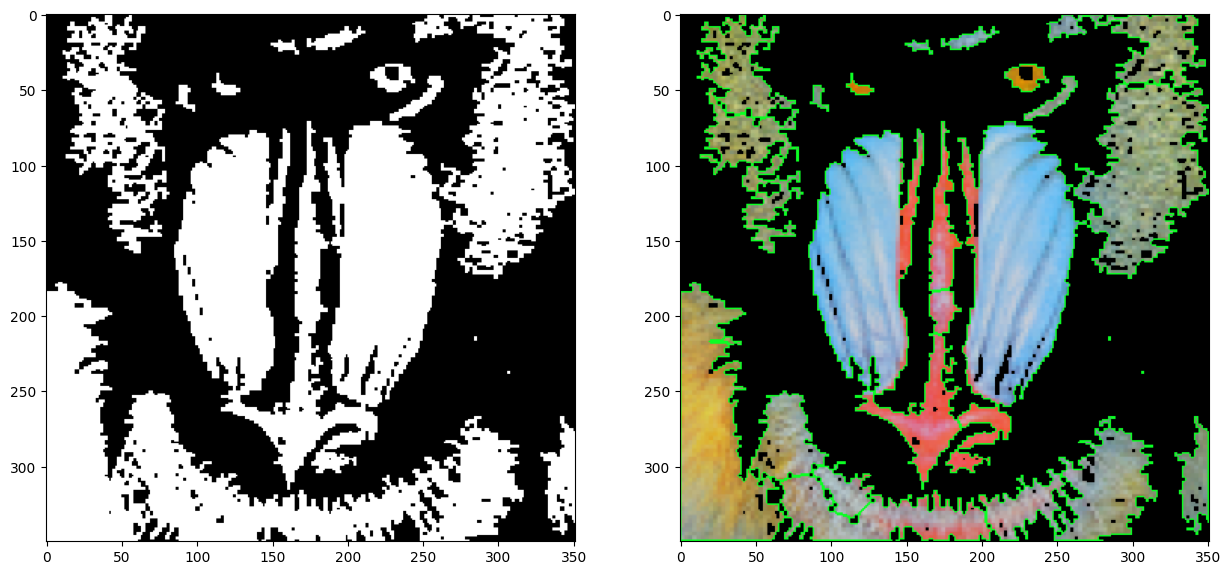

In [ ]:
# Найдем границы контуров и положим в маску все кроме метки 0
mask1 = np.zeros(image.shape[0:2], dtype="uint8")
total_area = 0
for label in np.unique(labels):
    if label < 2:
        continue
    # Create a mask
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255
    mask1 = mask1 + mask

    # Find contours and determine contour area
    cnts = cv.findContours(mask.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    c = max(cnts, key=cv.contourArea)
    area = cv.contourArea(c)
    total_area += area
    cv.drawContours(image, [c], -1, (36,255,12), 1)

result = cv.bitwise_and(image, image, mask=mask1)

plt.figure(figsize=(15,20))
plt.subplot(1, 2, 1)
plt.imshow(mask1, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()

### 4 Методы кластеризации.

#### K-средних

  Для алгоритма необходимо задать число кластеров (сегментов), после чего границы кластеров изменяются итерационно, минимизируя сумму расстояний от точек до центров кластеров (расстояние по яркости, например).
 <figure>
<center>
<img src='https://drive.google.com/uc?id=1ve80Czz0PmraB8OqkBs0OikQf6MxPzfG' />
<figcaption></figcaption></center>
</figure>

Алгоритм чувствителен к начальному выбору центров кластеров и не учитывает пространственную близость пикселей.




[[123]
 [ 78]
 [167]]


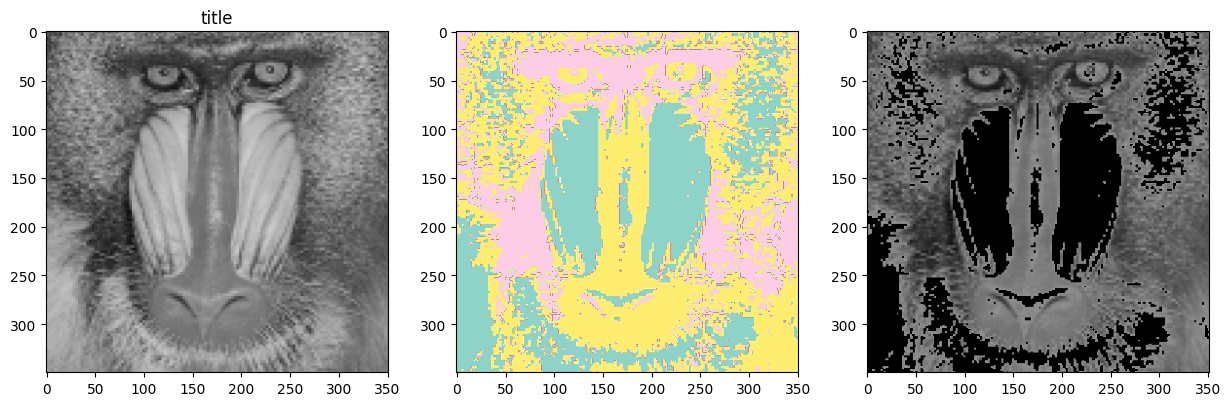

In [ ]:
## Методы кластеризации. K-средних
# Преобразуем изображение в оттенках серого в одномерный массив
pixels = gray.reshape(-1, 1)
# Задаем число кластеров для сегментации
K = 3
# С помощью библиотеки sklearn.cluster import KMeans проводим кластеризацию по яркости
kmeans = KMeans(n_clusters=K, random_state=0)
labels = kmeans.fit_predict(pixels)
cluster_centers = kmeans.cluster_centers_
print (np.uint8(cluster_centers))
# Каждому пикселю назначаем значение из центра кластера
segments = np.uint8(cluster_centers[labels].reshape(gray.shape))
# Удалим самые яркие пиксели
segments[segments==167] = 0
result = cv.bitwise_and(gray, gray, mask=segments)
# Отобразим избражения
plt.figure(figsize=(15,20))
plt.subplot(1, 3, 1).set_title('title')
plt.imshow(cv.cvtColor(gray, cv.COLOR_BGR2RGB))
plt.subplot(1, 3, 2)
plt.imshow(segments, cmap='Set3')
plt.subplot(1, 3, 3)
plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()


#### Сдвиг среднего (Mean shift)
  
 https://ru.wikipedia.org/wiki/%D0%A1%D0%B4%D0%B2%D0%B8%D0%B3_%D1%81%D1%80%D0%B5%D0%B4%D0%BD%D0%B5%D0%B3%D0%BE_%D0%B7%D0%BD%D0%B0%D1%87%D0%B5%D0%BD%D0%B8%D1%8F

 Метод основан на непараметрической оценке плотности распределения признаков пикселей (яркость, градиент и т.п.).
 Для непараметрической оценки применяются ядерные функции.
 Алгоритм сдвига среднего ищет локальные максимуму плотности распределения в n-мерном пространстве признаков.
  

    1 Задаем параметры окна (размер и местоположение).

    2 Вычисляем среднее значение данных в окне.

    3 Смещаем окно в координаты среднего значения.

    4 Повторяем до нахождения максимума, возвращаемся в п.1.

 <figure>
<center>
<img src='https://drive.google.com/uc?id=1Yrzv2W-N5LeM9v9ACWty2ZFRC3oPDpOh' />
<figcaption></figcaption></center>
</figure>

  Алгоритм не учитывает пространственную близость пикселей, но не требует задания количества кластеров.
  
  ### Алгоритм вычисляется достаточно долго...


Number of segments:  5


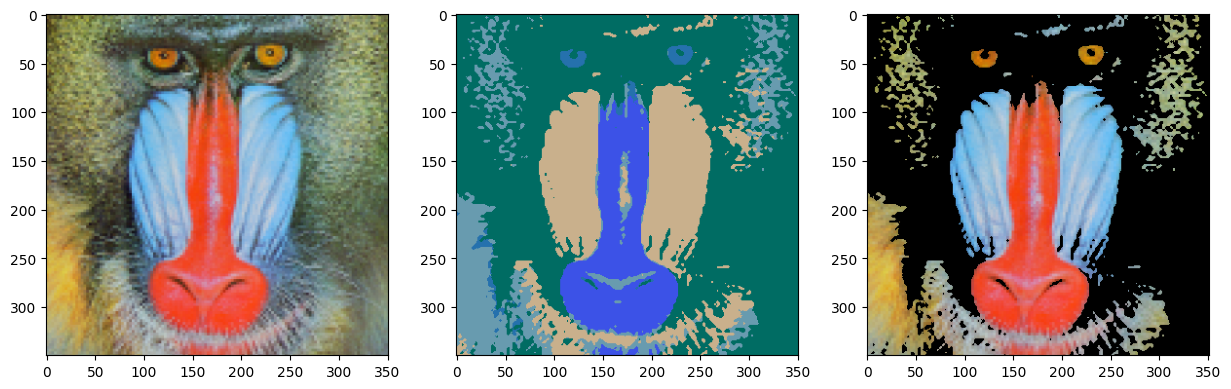

In [10]:
## Методы кластеризации. Сдвиг среднего (Mean shift)
# Сглаживаем чтобы уменьшить шум
blur_image = cv.medianBlur(image, 3)
# Выстраиваем пиксели в один ряд и переводим в формат с правающей точкой
flat_image = np.float32(blur_image.reshape((-1,3)))

# Используем meanshift из библиотеки sklearn
bandwidth = estimate_bandwidth(flat_image, quantile=.06, n_samples=3000)
ms = MeanShift(bandwidth=bandwidth, max_iter=800, bin_seeding=True)
ms.fit(flat_image)
labeled = ms.labels_

# получим количество сегментов
segments = np.unique(labeled)
print('Number of segments: ', segments.shape[0])

# получим средний цвет сегмента
total = np.zeros((segments.shape[0], 3), dtype=float)
count = np.zeros(total.shape, dtype=float)
for i, label in enumerate(labeled):
    total[label] = total[label] + flat_image[i]
    count[label] += 1
avg = total/count
avg = np.uint8(avg)
# Для каждого пискеля проставим средний цвет его сегмента
mean_shift_image = avg[labeled].reshape((image.shape))
# Маской скроем один из сегментов
mask1 = mean_shift_image[:,:,0]
mask1[mask1==89] = 0
mean_shift_with_mask_image = cv.bitwise_and(image, image, mask=mask1)
# Построим изображение
plt.figure(figsize=(15,20))
plt.subplot(1, 3, 1)
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.subplot(1, 3, 2)
plt.imshow(mean_shift_image, cmap='Set3')
plt.subplot(1, 3, 3)
plt.imshow(cv.cvtColor(mean_shift_with_mask_image, cv.COLOR_BGR2RGB))
plt.show()